В нашем распоряжении данные о заказах такси в аэропортах. Задача: спрогнозировать количество заказов такси.

# 1. Подготовка

Импортируем необходимые библиотеки:

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy import stats as st
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

from statsmodels.tsa.arima_model import ARIMA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyRegressor


from ast import literal_eval
import json
from tqdm import tqdm
from joblib import dump, load
from IPython.display import display
import time
import warnings

warnings.simplefilter("ignore") #будем игнорировать предупреждения
SEED = 42 #определяем константу, которая будет инициировать случайные числа

Загрузим данные из файла. Дату/время будем использовать в качестве индекса и попробуем загрузить в формате `datetime`:

In [ ]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates =[0])
print(display(data.head()))
print(data.info())

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB
None


Ресемплируем наши данные - рассчитаем среднее по каждому часу:

In [ ]:
data = data.resample('1H').sum()
print(display(data.head()))
print(data.info())

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
num_orders    4416 non-null int64
dtypes: int64(1)
memory usage: 69.0 KB
None


## Вывод

- Мы загрузили данные. Дату/время загрузили в формате `datetime` и использовали в качестве индекса таблицы.

- Мы ресемплировали данные - рассчитали среднее по каждому часу.

# 2. Анализ

По данным нашей таблицы построим график числа заказов в зависимости от даты/времени:

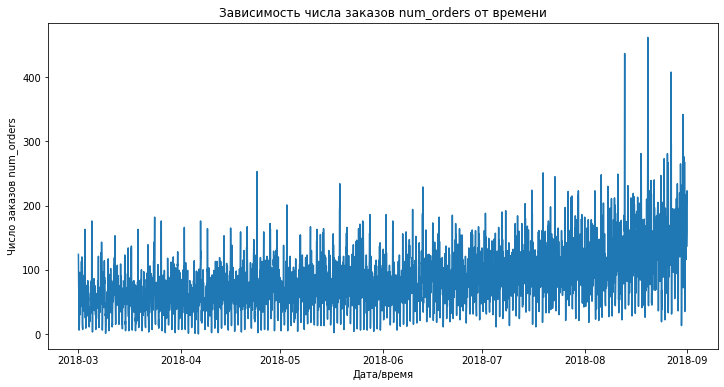

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(data['num_orders'])
plt.title('Зависимость числа заказов num_orders от времени')
plt.xlabel('Дата/время')
plt.ylabel('Число заказов num_orders')
plt.show()

Теперь применим скользящее среднее и посмотрим на графике:

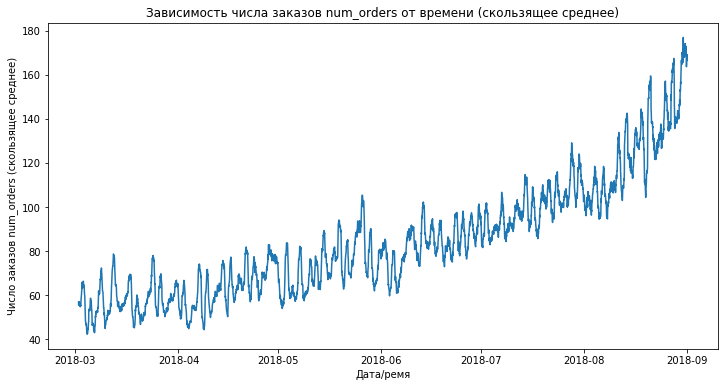

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(data['num_orders'].rolling(24).mean())
plt.title('Зависимость числа заказов num_orders от времени (скользящее среднее)')
plt.xlabel('Дата/ремя')
plt.ylabel('Число заказов num_orders (скользящее среднее)')
plt.show()

Линии на графике стали менее плотными. Используем эту возможность в дальнейшем на этапе моделирования.

Разложим временной ряд на тренд, сезонность и остаток. Посмотрим на графике в двух масштабах:

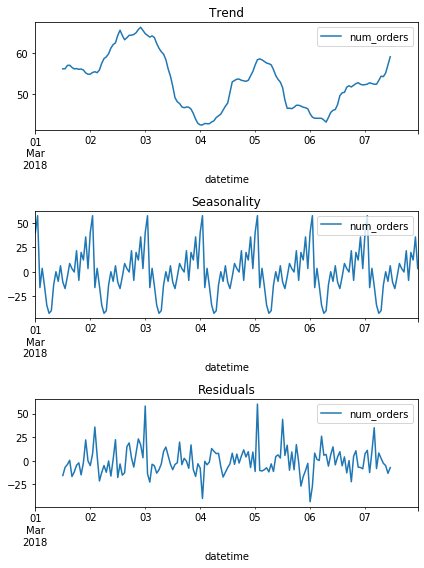

In [ ]:
decomposed = seasonal_decompose(data['2018-03-01':'2018-03-07'])

plt.figure(figsize=(6, 8))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())# < напишите код здесь >
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
# < напишите код здесь >
plt.title('Residuals')
plt.tight_layout()

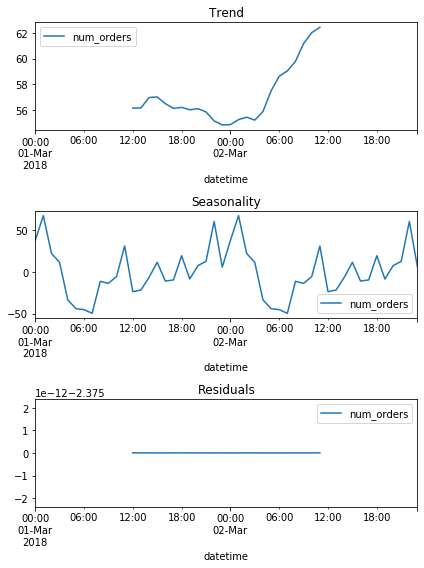

In [ ]:
decomposed = seasonal_decompose(data['2018-03-01':'2018-03-02'])

plt.figure(figsize=(6, 8))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())# < напишите код здесь >
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
# < напишите код здесь >
plt.title('Residuals')
plt.tight_layout()

Создадим функцию, которая создаст дополнительные признаки в нашей таблице, состоящие из элементов даты/времени по отдельности, скользящего среднего с параметром `rolling_mean_size` и сдвигов на шаг от 1 до `max_lag`. Применим эту функцию с произвольными параметрами. Удалим строки с незаполненными значениями и посмотрим на получившуюся таблицу:

In [ ]:
def make_features(data, max_lag, rolling_mean_size):
    data_features = data.copy()
    data_features['month'] = data_features.index.month
    data_features['day'] = data_features.index.day
    data_features['dayofweek'] = data_features.index.dayofweek
    data_features['hour'] = data_features.index.hour
    
    for lag in range(1, max_lag + 1):
        data_features['lag_{}'.format(lag)] = data_features['num_orders'].shift(lag)

    data_features['rolling_mean'] = data_features['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data_features

In [ ]:
data_features = make_features(data, 2, 3)
data_features = data_features.dropna()
print(display(data_features.head()))

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,rolling_mean
datetime,,,,,,,,
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,93.333333
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,74.000000
2018-03-01 05:00:00,6,3,1,3,5,43.0,66.0,60.000000
2018-03-01 06:00:00,12,3,1,3,6,6.0,43.0,38.333333
2018-03-01 07:00:00,15,3,1,3,7,12.0,6.0,20.333333


None


Построим диаграмму отношений между всеми парами признаков:

In [ ]:
def pairplot(data):
    plt.figure(figsize = (20,20))
    sns.pairplot(data=data)
    plt.show()

<Figure size 1440x1440 with 0 Axes>

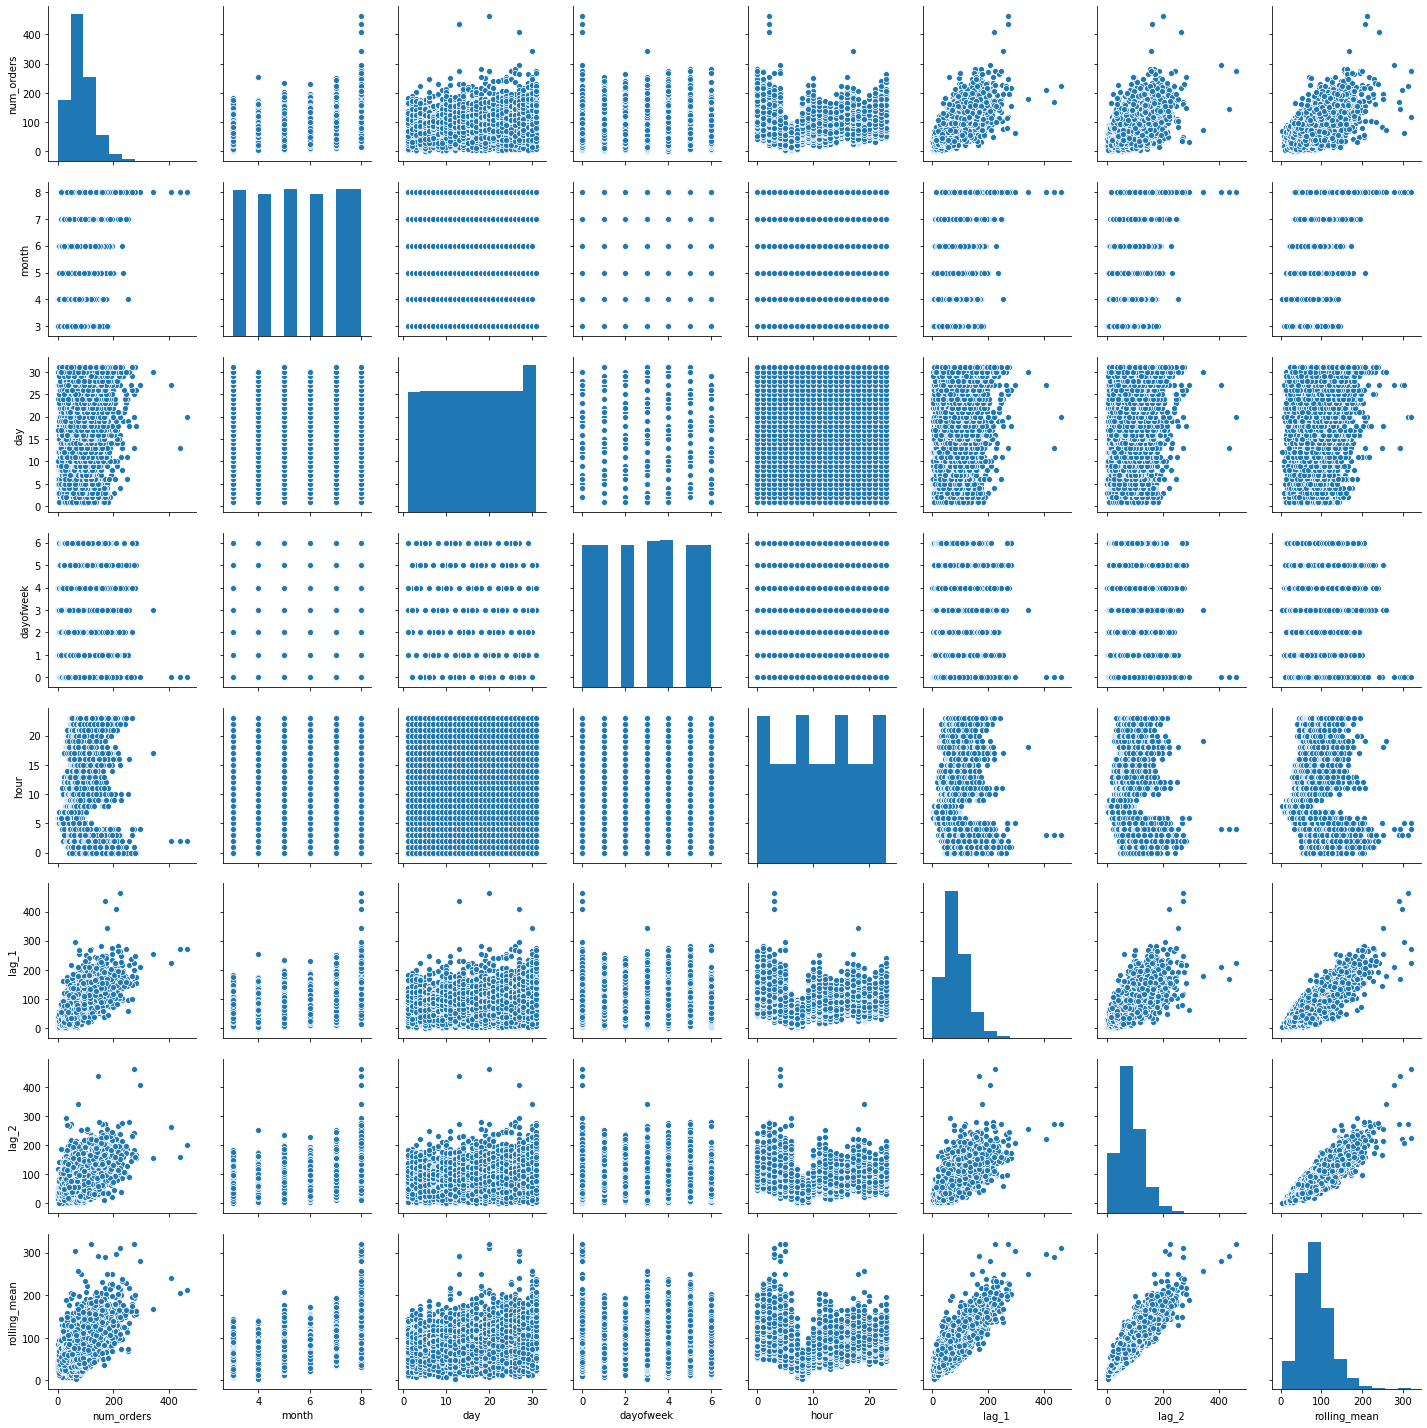

In [ ]:
pairplot(data_features)

Видно, что некоторые пары признаков имеют друг от друга линейную зависимость. Это должно быть видно также по высокой корреляции. Построим функцию для отображения рейтинга и посмотрим на корреляцию целевого признака `num_orders` с прочими признаками:

In [ ]:
def ranking(y, title='', xlabel='', ylabel=''):
    y_pos = np.arange(len(y),0,-1)
    plt.figure(figsize=(5,5))
    cmap = ListedColormap(sns.color_palette("GnBu_d"))
    bar_colors = cmap(y.values)
    plt.barh(y_pos, width=y, height=0.6, left=None, align='center', color=bar_colors, alpha = 0.8)
    plt.yticks(y_pos, y.index)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    for p, c, ch in zip(y_pos, y.index, round(y,4)):
        plt.annotate(str(ch), xy=(ch if ch>0 else 0, p), va='center')

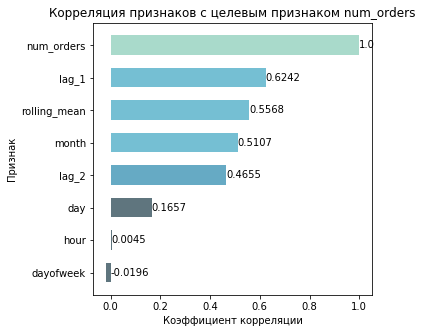

In [ ]:
ranking(data_features.corr()['num_orders'].sort_values(ascending = False), 
        title='Корреляция признаков с целевым признаком num_orders', 
        xlabel='Коэффициент корреляции', 
        ylabel='Признак')

Видно, что коэффициент корреляции для ряда признаков высокий.

Построим автокорреляционную функцию и частичную автокорреляционную функцию и отобразим на графиках. Число пиков на этих графиках 5 и 5 будем использовано в дальнейшем для построения модели `ARIMA`. 

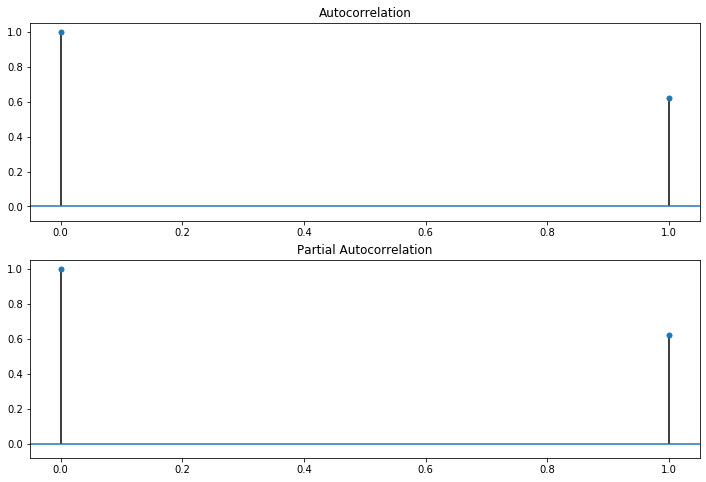

In [ ]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data_features['num_orders'], lags=1, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data_features['num_orders'], lags=1, ax=ax2)

## Вывод

- Мы построили график числа заказов в зависимости от даты/времени. Сравнили с графиком со скользящим средним. 

- Разложили временной ряд на тренд, сезонность и остаток. Посмотрели на графике в двух масштабах.

- Создали функцию, которая создает дополнительные признаки в таблице, состоящие из элементов даты/времени по отдельности, скользящего среднего с параметром `rolling_mean_size` и сдвигов на шаг от 1 до `max_lag`. Применили эту функцию с произвольными параметрами. Удалили строки с незаполненными значениями.

- Построили диаграмму отношений между всеми парами признаков. Видно, что некоторые пары признаков имеют друг от друга линейную зависимость. 

- Построили функцию для отображения рейтинга и посмотрели на корреляцию целевого признака `num_orders` с прочими признаками. Коэффициент корреляции высокий для ряда признаков.

- Построили автокорреляционную функцию и частичную автокорреляционную функцию и отобразили на графиках. Число пиков на этих графиках 5 и 5 будем использовано в дальнейшем для построения модели `ARIMA`.

# 3. Обучение

Создадим функцию для подготовки данных. Она будет брать изначальную загруженную таблицу и создавать дополнительные признаки, как мы делали ранее, состоящие из элементов даты/времени по отдельности, скользящего среднего с параметром `rolling_mean_size` и сдвигов на шаг от 1 до `max_lag`, только теперь мы сможем менять эти параметры.

Далее признаки будут делиться на целевой и прочие, масштабироваться при помощи `StandardScaler` и разбиваться при помощи функции `train_test_split` на тренировочную, валидационную и тестовую выборки. 

In [ ]:
def data_prepare(data, max_lag, rolling_mean_size):
    
    data_features = make_features(data, max_lag, rolling_mean_size)
    data_features = data_features.dropna()
    
    features = data_features.drop('num_orders', axis = 1)
    target = data_features['num_orders']
    
    scaler = StandardScaler(with_mean=False)
    features = scaler.fit_transform(features)
    
    features_train_val, features_test, target_train_val, target_test = train_test_split(features, target, test_size=0.10, shuffle = False)
    print(features_train_val.shape, features_test.shape, target_train_val.shape, target_test.shape)

    features_train, features_val, target_train, target_val = train_test_split(features_train_val, target_train_val, test_size=0.10, shuffle = False)
    print(features_train.shape, features_val.shape, target_train.shape, target_val.shape)
    
    return features_train, features_val, features_test, target_train, target_val, target_test, data_features

Создадим функцию, считающую искомую метрику `rmse`:

In [ ]:
def rmse(target_val, target_predicted):
    return np.sqrt(mean_squared_error(target_val, target_predicted))

Создадим функцию, которая будет обучать модель, делать предсказания и рассчитывать метрику `rmse`:

In [ ]:
def fit_predict(model, features_train, features_val, target_train, target_val):
    
    start_time = time.time()
    model.fit(features_train, target_train)
    print("Время обучения: %s секунд" % (time.time() - start_time))
    
    start_time = time.time()
    target_predicted = model.predict(features_val)
    prediction_time = (time.time() - start_time)
    print("Время предсказания: %s секунд" % prediction_time)
    
    rmse_ = rmse(target_val, target_predicted)
    print('RMSE=', rmse_)
    print()
    return rmse_, target_predicted

Создадим функцию, которая будет выводить рейтинг важности признаков для модели.

In [ ]:
def feature_importance(data_features, feature_importance):
       
    importances = pd.DataFrame(feature_importance, columns = ['feature_importances'], index = data_features.drop('num_orders', axis = 1).columns)
    importances = importances.sort_values(by = 'feature_importances', ascending = False).head(10)
    ranking(importances['feature_importances'], title='Feature importance', xlabel='importance', ylabel='feature')

Создадим переменную, которая будет обращаться к метрике `rsme` при использовании функции поиска наилучших гиперпараметров моделей.

In [ ]:
rmse_scorer = make_scorer(score_func = rmse, greater_is_better=False)
    

Создадим функцию поиска наилучших гиперпараметров моделей:

In [ ]:
def best_param(model, params, features_train, target_train):
    
    grid = GridSearchCV(model, param_grid=params, scoring = rmse_scorer, cv=3, n_jobs=-1)
    grid.fit(features_train, target_train)
    print( grid.best_params_)
    return grid.best_params_

Создадим функцию, строящую модель линейной регрессии, использующую предыдущие функции и выводящую результаты (гиперпараметры и `rmse`) в таблицу.

In [ ]:
def LinearRegr(features_train, features_val, target_train, target_val, score_table):
    print('LinearRegression:')
    params= {'fit_intercept': [True, False],
              'normalize': [True, False]
             }
    model = LinearRegression()
    best = best_param(model, params, features_train, target_train)
    model = LinearRegression(**best)
    
    score_table.loc['LinearRegression', 'params']=str(best)
    score_table.loc['LinearRegression', 'rmse'], _ = fit_predict(model, features_train, features_val, target_train, target_val)
    print()
    return score_table

Создадим функцию, строящую модель случайного леса, использующую предыдущие функции и выводящую результаты (гиперпараметры и `rmse`) в таблицу.

In [ ]:
def RandomForest(features_train, features_val, target_train, target_val, score_table):
    print('RandomForest:')
    params= ({'n_estimators': [50, 100, 200, 500],
             'min_samples_leaf': [2, 3],
             'min_samples_split': [2, 3], 
             'random_state': [SEED]
             })
 
    model = RandomForestRegressor(random_state= SEED)
    best = best_param(model, params, features_train, target_train)
    model = RandomForestRegressor(**best)
    
    score_table.loc['RandomForest', 'params']=str(best)
    score_table.loc['RandomForest', 'rmse'],_= fit_predict(model, features_train, features_val, target_train, target_val)
    print()
    return score_table

Создадим функцию, строящую модель ближайших соседей, использующую предыдущие функции и выводящую результаты (гиперпараметры и `rmse`) в таблицу.

In [ ]:
def KNeighbors(features_train, features_val, target_train, target_val, score_table):
    print('KNeighbors:')
    params= ({'weights': ['uniform', 'distance'],
              'leaf_size': [10, 50, 100, 200, 500]
             })

    model = KNeighborsRegressor()
    best = best_param(model, params, features_train, target_train)
    model = KNeighborsRegressor(**best)
    
    score_table.loc['KNeighbors', 'params']=str(best)
    score_table.loc['KNeighbors', 'rmse'],_= fit_predict(model, features_train, features_val, target_train, target_val)
    print()
    return score_table

Создадим функцию, строящую модель по наивному байесовскому подходу, использующую предыдущие функции и выводящую результаты (гиперпараметры и `rmse`) в таблицу.

In [ ]:
def Gaussian(features_train, features_val, target_train, target_val, score_table):
    print('GaussianNB:')
    params= ({'var_smoothing': [1e-8,1e-9,1e-10]})

    model = GaussianNB()
    best=best_param(model, params, features_train, target_train)
    model = GaussianNB(**best)
    
    score_table.loc['GaussianNB', 'params']=str(best)
    score_table.loc['GaussianNB', 'rmse'],_= fit_predict(model, features_train, features_val, target_train, target_val)
    print()
    return score_table

Создадим функцию, строящую модель градиентного бустинга `CatBoost`, использующую предыдущие функции и выводящую результаты (гиперпараметры и `rmse`) в таблицу.

In [ ]:
def CatBoost(features_train, features_val, target_train, target_val, score_table):
    print('CatBoost:')
    params = ({'learning_rate': [0.01, 0.05, 0.1, 0.5],
             'l2_leaf_reg': [5,10],
             'random_state': [SEED]
             })
    model = CatBoostRegressor(verbose = False)
    best = best_param(model, params, features_train, target_train)
    model = CatBoostRegressor(**best)
    
    score_table.loc['CatBoost', 'params']=str(best)
    score_table.loc['CatBoost', 'rmse'],_= fit_predict(model, features_train, features_val, target_train, target_val)
    #feature_importance(model.get_feature_importance())
    print()
    return score_table

Создадим функцию, строящую модель `ARIMA`, выводящую результаты (гиперпараметры и `rmse`) в таблицу. В качестве гиперпараметов используем данные, полученные из графиков автокорреляционной и частичной автокорреляционной функций. 

In [ ]:
def arima(data, score_table):
    data_train_val, data_test = train_test_split(data, test_size=0.10, shuffle = False)
    data_train, data_val = train_test_split(data_train_val, test_size=0.10, shuffle = False)

    model = ARIMA(data_train, order=(2,1,2), freq='H').fit(full_output=False, disp=0)
    pred = model.predict(data_val['num_orders'].index.min(),data_val['num_orders'].index.max(), typ='levels')
    rmse_ = rmse(data_val, pred)
    score_table.loc['ARIMA', 'params']='{order:(2,1,2)}'
    score_table.loc['ARIMA', 'rmse']= rmse_
    return score_table
    

Вновь установим произвольные значения `max_lag` и `rolling_mean_size`, используем функцию подготовки данных, создадим таблицу, в которую будем записывать все результаты на валидации и 'запустим' все модели, используя тренировочную и валидационную выборки. 

In [ ]:
max_lag=5
rolling_mean_size=24
features_train, features_val, features_test, target_train, target_val, target_test, data_features = data_prepare(data, max_lag, rolling_mean_size)
        
score_table = pd.DataFrame('0', columns = ['params','rmse'], index = ['LinearRegression',
                                                                                    'RandomForest', 
                                                                                    'KNeighbors', 
                                                                                    'GaussianNB',
                                                                                    'CatBoost',
                                                                                    'ARIMA'])
score_table =  LinearRegr(features_train, features_val, target_train, target_val, score_table)
score_table = RandomForest(features_train, features_val, target_train, target_val, score_table)
score_table = KNeighbors(features_train, features_val, target_train, target_val, score_table)
score_table = Gaussian(features_train, features_val, target_train, target_val, score_table)
score_table = CatBoost(features_train, features_val, target_train, target_val, score_table)
score_table = arima(data, score_table)

(3952, 10) (440, 10) (3952,) (440,)
(3556, 10) (396, 10) (3556,) (396,)
LinearRegression:
{'fit_intercept': False, 'normalize': True}
Время обучения: 0.09186077117919922 секунд
Время предсказания: 0.0002377033233642578 секунд
RMSE= 40.56331674015911


RandomForest:
{'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 50, 'random_state': 42}
Время обучения: 0.7853212356567383 секунд
Время предсказания: 0.0076198577880859375 секунд
RMSE= 31.68089892447936


KNeighbors:
{'leaf_size': 10, 'weights': 'distance'}
Время обучения: 0.0027403831481933594 секунд
Время предсказания: 0.026572704315185547 секунд
RMSE= 39.61752726894976


GaussianNB:
{'var_smoothing': 1e-09}
Время обучения: 0.01657867431640625 секунд
Время предсказания: 0.014659643173217773 секунд
RMSE= 47.57452951512877


CatBoost:
{'l2_leaf_reg': 10, 'learning_rate': 0.05, 'random_state': 42}
0:	learn: 35.2925602	total: 5.88ms	remaining: 5.87s
1:	learn: 34.6087222	total: 14.5ms	remaining: 7.22s
2:	learn: 34.0100333	total

Посмотрим на таблицу результатов на валидации и найдем в ней наилучшую модель:

In [ ]:
print(display(score_table))
params_best_val = score_table[score_table['rmse'] == score_table['rmse'].min()]['params'][0]
print('Лучшая модель:', params_best_val)

,params,rmse
LinearRegression,"{'fit_intercept': False, 'normalize': True}",40.5633
RandomForest,"{'min_samples_leaf': 3, 'min_samples_split': 2...",31.6809
KNeighbors,"{'leaf_size': 10, 'weights': 'distance'}",39.6175
GaussianNB,{'var_smoothing': 1e-09},47.5745
CatBoost,"{'l2_leaf_reg': 10, 'learning_rate': 0.05, 'ra...",32.6197
ARIMA,"{order:(2,1,2)}",46.5665


None
Лучшая модель: {'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 50, 'random_state': 42}


Лучшая модель - случайный лес с подобранными гиперпараметрами. Напишем "короткую" функцию для запуска модели случайного леса, без подбора гиперпараметров. Далее будем запускать случайный лес, перебирая значения  `max_lag` и `rolling_mean_size`. Все результаты запишем в таблицу.

In [ ]:
def CatBoost_short(features_train, features_val, target_train, target_val, score_table):
    params = literal_eval(params_best_val)   
    model = CatBoostRegressor(**params, verbose = False)
    
    score_table.loc['CatBoost', 'params']=str(params)
    score_table.loc['CatBoost', 'rmse'], _ = fit_predict(model, features_train, features_val, target_train, target_val)
    print()
    
    return score_table

In [ ]:
def RandomForest_short(features_train, features_val, target_train, target_val, score_table):
    params = literal_eval(params_best_val)   
    model = RandomForestRegressor(**params, )
    
    score_table.loc['RandomForest', 'params']=str(params)
    score_table.loc['RandomForest', 'rmse'], _ = fit_predict(model, features_train, features_val, target_train, target_val)
    print()
    
    return score_table

In [ ]:
large_table =  pd.DataFrame(columns = ['max_lag','rolling_mean_size', 'best_model','params','rmse'])
i=0
for max_lag in range(2, 20, 2):
    for rolling_mean_size in range(2, 30, 2):
        
        print('max_lag = ', max_lag, ', rolling_mean_size = ', rolling_mean_size)
        features_train, features_val, features_test, target_train, target_val, target_test, data_features = data_prepare(data, max_lag, rolling_mean_size)
        
        score_table = pd.DataFrame('0', columns = ['params','rmse'], index = ['RandomForest'])

        score_table = RandomForest_short(features_train, features_val, target_train, target_val, score_table)
                
        large_table.loc[i,'max_lag'] = max_lag
        large_table.loc[i,'rolling_mean_size'] = rolling_mean_size
                       
        score_table['rmse'] = score_table['rmse'].astype('float64')
        row = score_table[score_table['rmse'] == score_table['rmse'].min()].copy().reset_index()
        
        large_table.loc[i,'best_model'] = row.loc[0, 'index']
        large_table.loc[i,'params'] = row.loc[0, 'params']
        large_table.loc[i,'rmse'] = row.loc[0, 'rmse']
    
        i+=1        

max_lag =  2 , rolling_mean_size =  2
(3972, 7) (442, 7) (3972,) (442,)
(3574, 7) (398, 7) (3574,) (398,)
Время обучения: 0.4846155643463135 секунд
Время предсказания: 0.0075032711029052734 секунд
RMSE= 34.07009956819906


max_lag =  2 , rolling_mean_size =  4
(3970, 7) (442, 7) (3970,) (442,)
(3573, 7) (397, 7) (3573,) (397,)
Время обучения: 0.4877307415008545 секунд
Время предсказания: 0.0068683624267578125 секунд
RMSE= 34.11433771852829


max_lag =  2 , rolling_mean_size =  6
(3969, 7) (441, 7) (3969,) (441,)
(3572, 7) (397, 7) (3572,) (397,)
Время обучения: 0.547304630279541 секунд
Время предсказания: 0.007644176483154297 секунд
RMSE= 32.80763200998109


max_lag =  2 , rolling_mean_size =  8
(3967, 7) (441, 7) (3967,) (441,)
(3570, 7) (397, 7) (3570,) (397,)
Время обучения: 0.48861169815063477 секунд
Время предсказания: 0.007581949234008789 секунд
RMSE= 31.856350617242178


max_lag =  2 , rolling_mean_size =  10
(3965, 7) (441, 7) (3965,) (441,)
(3568, 7) (397, 7) (3568,) (397,)
Вр

Посмотрим на получившуюся таблицу зависимости `rmse` от наших параметров:

In [ ]:
print(display(large_table))

,max_lag,rolling_mean_size,best_model,params,rmse
0,2,2,RandomForest,"{'min_samples_leaf': 3, 'min_samples_split': 2...",34.0701
1,2,4,RandomForest,"{'min_samples_leaf': 3, 'min_samples_split': 2...",34.1143
2,2,6,RandomForest,"{'min_samples_leaf': 3, 'min_samples_split': 2...",32.8076
3,2,8,RandomForest,"{'min_samples_leaf': 3, 'min_samples_split': 2...",31.8564
4,2,10,RandomForest,"{'min_samples_leaf': 3, 'min_samples_split': 2...",31.814
...,...,...,...,...,...
121,18,20,RandomForest,"{'min_samples_leaf': 3, 'min_samples_split': 2...",31.6721
122,18,22,RandomForest,"{'min_samples_leaf': 3, 'min_samples_split': 2...",31.6027
123,18,24,RandomForest,"{'min_samples_leaf': 3, 'min_samples_split': 2...",31.5256
124,18,26,RandomForest,"{'min_samples_leaf': 3, 'min_samples_split': 2...",31.1949


None


Найдем по таблице наилучшие значения параметров, их мы и будем использовать на тесте:

In [ ]:
best_max_lag = large_table[large_table['rmse'] == large_table['rmse'].min()]['max_lag'].values[0]
best_rolling_mean_size = large_table[large_table['rmse'] == large_table['rmse'].min()]['rolling_mean_size'].values[0]
best_score_val = large_table[large_table['rmse'] == large_table['rmse'].min()]['rmse'].values[0]
model_best = large_table[large_table['rmse'] == large_table['rmse'].min()]['best_model'].values[0]
params_best = large_table[large_table['rmse'] == large_table['rmse'].min()]['params'].values[0]
print('Best max_lag =', best_max_lag)
print('Best rolling_mean_size =', best_rolling_mean_size)
print('Best score val: rmse =', best_score_val)
print('Best model: ', model_best)
print('Best params: ', params_best)


Best max_lag = 6
Best rolling_mean_size = 26
Best score val: rmse = 30.814383685926064
Best model:  RandomForest
Best params:  {'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 50, 'random_state': 42}


Построим графики зависимости метрики `mae`от параметров `max_lag` и `rolling_mean_size`. 

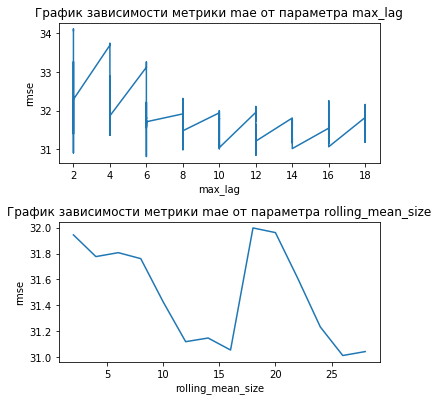

In [ ]:
plt.figure(figsize=(6, 8))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
plt.plot(large_table['max_lag'], large_table['rmse'])
plt.xlabel('max_lag')
plt.ylabel('rmse')
plt.title('График зависимости метрики mae от параметра max_lag')
plt.subplot(312)
plt.plot(large_table[large_table['max_lag']==10]['rolling_mean_size'], large_table[large_table['max_lag']==10]['rmse'])
plt.title('График зависимости метрики mae от параметра rolling_mean_size')
plt.xlabel('rolling_mean_size')
plt.ylabel('rmse')
plt.tight_layout()

## Вывод

- Мы создали функцию для подготовки данных. Она берет изначальную загруженную таблицу и создает дополнительные признаки, как мы делали ранее, состоящие из элементов даты/времени по отдельности, скользящего среднего с параметром `rolling_mean_size` и сдвигов на шаг от 1 до `max_lag`, только теперь мы сможем менять эти параметры. Далее признаки разделили на целевой и прочие, масштабировали при помощи `StandardScaler` и разбили при помощи функции `train_test_split` на тренировочную, валидационную и тестовую выборки. 

- Создали функцию, считающую искомую метрику `rmse` и переменную, которая будет обращаться к метрике `rsme` при использовании функции поиска наилучших гиперпараметров моделей.

- Создали функцию, которая обучает модель, делает предсказания и рассчитывает метрику `rmse`.

- Создали функцию, которая выводит рейтинг важности признаков для модели.

- Создали функцию поиска наилучших гиперпараметров моделей.

- Создали функцию, строящую модель линейной регрессии, использующую предыдущие функции и выводящую результаты (гиперпараметры и `rmse`) в таблицу.

- Создали функцию, строящую модель случайного леса, использующую предыдущие функции и выводящую результаты (гиперпараметры и `rmse`) в таблицу.

- Создали функцию, строящую модель ближайших соседей, использующую предыдущие функции и выводящую результаты (гиперпараметры и `rmse`) в таблицу.

- Создали функцию, строящую модель по наивному байесовскому подходу, использующую предыдущие функции и выводящую результаты (гиперпараметры и `rmse`) в таблицу.

- Создали функцию, строящую модель градиентного бустинга `CatBoost`, использующую предыдущие функции и выводящую результаты (гиперпараметры и `rmse`) в таблицу.

- Создали функцию, строящую модель `ARIMA`, выводящую результаты (гиперпараметры и `rmse`) в таблицу. В качестве гиперпараметов используем данные, полученные из графиков автокорреляционной и частичной автокорреляционной функций.

- Установили произвольные значения `max_lag` и `rolling_mean_size`, использовали функцию подготовки данных, создали таблицу, в которую будут записываться все результаты на валидации и 'запустили' все модели, используя тренировочную и валидационную выборки. 

- Посмотрели на таблицу результатов на валидации и найшлидем в ней наилучшую модель. Лучшая модель - случайный лес с подобранными гиперпараметрами.

- Написали "короткую" функцию для запуска модели случайного леса, без подбора гиперпараметров. Далее запустили случайный лес, перебирая значения  `max_lag` и `rolling_mean_size`. Все результаты записали в таблицу. Нашли по таблице наилучшие значения параметров.

- Построили графики зависимости метрики `mae`от параметров `max_lag` и `rolling_mean_size`. 

# 4. Тестирование

Построим заново модель с наилучшими параметрами и обучим ее на тренировочныз данных. Найдем `rmse` на тестовой выборке и построим рейтинг важности признаков.

In [ ]:
score_test_table = pd.DataFrame('0', columns = ['params','rmse'], index = ['RandomForest', 'Dummy'])

features_train, features_val, features_test, target_train, target_val, target_test, data_features = data_prepare(data, best_max_lag, best_rolling_mean_size)
       
model = RandomForestRegressor(**literal_eval(params_best))  
score_test_table.loc['RandomForest', 'params']=str(params_best)
score_test_table.loc['RandomForest', 'rmse'], target_predicted = fit_predict(model, features_train, features_test, target_train, target_test)



(3951, 11) (439, 11) (3951,) (439,)
(3555, 11) (396, 11) (3555,) (396,)
Время обучения: 0.8664114475250244 секунд
Время предсказания: 0.007653713226318359 секунд
RMSE= 47.77179920291127



In [ ]:
score_test_table[score_test_table.index == 'RandomForest']

,params,rmse
RandomForest,"{'min_samples_leaf': 3, 'min_samples_split': 2...",47.7718


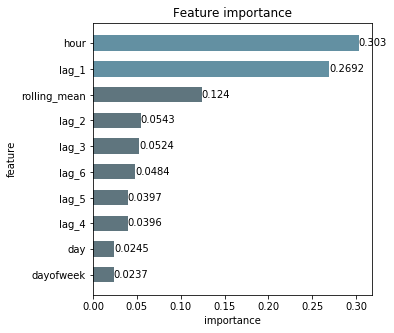

In [ ]:
feature_importance(data_features, model.feature_importances_)

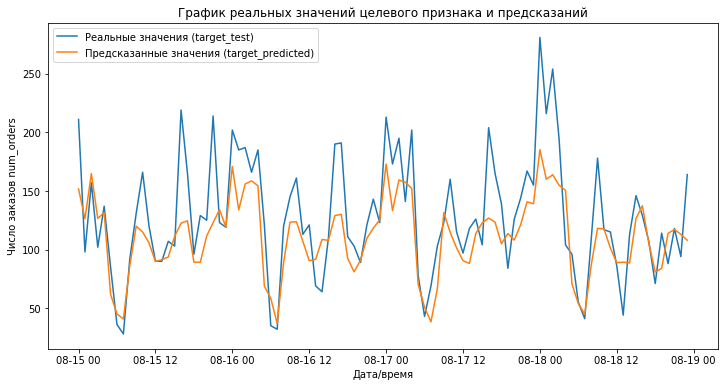

In [ ]:
data_features = make_features(data, max_lag, rolling_mean_size)
data_features = data_features.dropna()
data_train_val, data_test = train_test_split(data_features, test_size=0.10, shuffle = False)

data_test['target_test'] = target_test
data_test['target_predicted'] = target_predicted
plt.figure(figsize=(12, 6))
plt.plot(data_test['target_test']['2018-08-15':'2018-08-18'])
plt.plot(data_test['target_predicted']['2018-08-15':'2018-08-18'])
plt.title('График реальных значений целевого признака и предсказаний')
plt.xlabel('Дата/время')
plt.ylabel('Число заказов num_orders')
plt.legend(['Реальные значения (target_test)', 'Предсказанные значения (target_predicted)'])
plt.show()

Для сравнения найдем искомую метрику для константной модели, построенной из медианы тренировочной выборки. 

In [ ]:
model = DummyRegressor(strategy = 'median')
score_test_table.loc['Dummy', 'rmse'],_= fit_predict(model, features_train, features_test, target_train, target_test)
score_test_table.loc['Dummy', 'params']="{'strategy': ('median')}"

Время обучения: 0.0009219646453857422 секунд
Время предсказания: 0.0001201629638671875 секунд
RMSE= 88.73800088926008



In [ ]:
score_test_table

,params,rmse
RandomForest,"{'min_samples_leaf': 3, 'min_samples_split': 2...",47.7718
Dummy,{'strategy': ('median')},88.738


Видно, что наша модель дает существенно лучший результат, чем константная.

## Вывод

- Мы построили заново модель с наилучшими параметрами и обучили ее на тренировочныз данных. Нашли `rmse` на тестовой выборке и построили рейтинг важности признаков.

- Для сравнения нашли искомую метрику для константной модели, построенной из медианы тренировочной выборки. Видно, что наша модель дает существенно лучший результат, чем константная.

## Общий вывод

- Мы загрузили данные. Дату/время загрузили в формате `datetime` и использовали в качестве индекса таблицы.

- Мы ресемплировали данные - рассчитали среднее по каждому часу.

- Мы построили график числа заказов в зависимости от даты/времени. Сравнили с графиком со скользящим средним. 

- Разложили временной ряд на тренд, сезонность и остаток. Посмотрели на графике в двух масштабах.

- Создали функцию, которая создает дополнительные признаки в таблице, состоящие из элементов даты/времени по отдельности, скользящего среднего с параметром `rolling_mean_size` и сдвигов на шаг от 1 до `max_lag`. Применили эту функцию с произвольными параметрами. Удалили строки с незаполненными значениями.

- Построили диаграмму отношений между всеми парами признаков. Видно, что некоторые пары признаков имеют друг от друга линейную зависимость. 

- Построили функцию для отображения рейтинга и посмотрели на корреляцию целевого признака `num_orders` с прочими признаками. Коэффициент корреляции высокий для ряда признаков.

- Построили автокорреляционную функцию и частичную автокорреляционную функцию и отобразили на графиках. Число пиков на этих графиках 5 и 5 будем использовано в дальнейшем для построения модели `ARIMA`.

- Мы создали функцию для подготовки данных. Она берет изначальную загруженную таблицу и создает дополнительные признаки, как мы делали ранее, состоящие из элементов даты/времени по отдельности, скользящего среднего с параметром `rolling_mean_size` и сдвигов на шаг от 1 до `max_lag`, только теперь мы сможем менять эти параметры. Далее признаки разделили на целевой и прочие, масштабировали при помощи `StandardScaler` и разбили при помощи функции `train_test_split` на тренировочную, валидационную и тестовую выборки. 

- Создали функцию, считающую искомую метрику `rmse` и переменную, которая будет обращаться к метрике `rsme` при использовании функции поиска наилучших гиперпараметров моделей.

- Создали функцию, которая обучает модель, делает предсказания и рассчитывает метрику `rmse`.

- Создали функцию, которая выводит рейтинг важности признаков для модели.

- Создали функцию поиска наилучших гиперпараметров моделей.

- Создали функцию, строящую модель линейной регрессии, использующую предыдущие функции и выводящую результаты (гиперпараметры и `rmse`) в таблицу.

- Создали функцию, строящую модель случайного леса, использующую предыдущие функции и выводящую результаты (гиперпараметры и `rmse`) в таблицу.

- Создали функцию, строящую модель ближайших соседей, использующую предыдущие функции и выводящую результаты (гиперпараметры и `rmse`) в таблицу.

- Создали функцию, строящую модель по наивному байесовскому подходу, использующую предыдущие функции и выводящую результаты (гиперпараметры и `rmse`) в таблицу.

- Создали функцию, строящую модель градиентного бустинга `CatBoost`, использующую предыдущие функции и выводящую результаты (гиперпараметры и `rmse`) в таблицу.

- Создали функцию, строящую модель `ARIMA`, выводящую результаты (гиперпараметры и `rmse`) в таблицу. В качестве гиперпараметов используем данные, полученные из графиков автокорреляционной и частичной автокорреляционной функций.

- Установили произвольные значения `max_lag` и `rolling_mean_size`, использовали функцию подготовки данных, создали таблицу, в которую будут записываться все результаты на валидации и 'запустили' все модели, используя тренировочную и валидационную выборки. 

- Посмотрели на таблицу результатов на валидации и найшлидем в ней наилучшую модель. Лучшая модель - случайный лес с подобранными гиперпараметрами.

- Написали "короткую" функцию для запуска модели случайного леса, без подбора гиперпараметров. Далее запустили случайный лес, перебирая значения  `max_lag` и `rolling_mean_size`. Все результаты записали в таблицу. Нашли по таблице наилучшие значения параметров.

- Построили графики зависимости метрики `mae`от параметров `max_lag` и `rolling_mean_size`.

- Мы построили заново модель с наилучшими параметрами и обучили ее на тренировочныз данных. Нашли `rmse` на тестовой выборке и построили рейтинг важности признаков.

- Для сравнения нашли искомую метрику для константной модели, построенной из медианы тренировочной выборки. Видно, что наша модель дает существенно лучший результат, чем константная.